# NLP Project#2 : Vector Space Semantics for Similarity between Eastenders Characters

In this assignment, you will be creating a vector representation of a document containing lines spoken by a character in the Eastenders script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximially distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this coursework stipulates you can only use a maximum of the first **400 lines** of each character in the training data to create the training documents, and a maximum of the first **40 lines** in the test data (from `test.csv`). This makes it more challenging, as number of lines spoken by a character can't be used directly or otherwise as a feature.

A simple vector representation for each character document is done for you to start with in this code, as is the pipeline of similarity based information retrieval based evaluation. You need to improve the character vector representations by pre-processing, feature extraction and transformation techniques, as per Questions 1-4 below, which you need to complete as instructed.

In [1]:
# You may need to run this first- uncomment if so
!pip install nltk
!pip install sklearn
!pip install matplot
!pip install seaborn
!pip install textblob
!pip install pandas
!pip install python-crfsuite
!pip install contractions
!pip install unidecode
!pip install inflect

In [2]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import unidecode
import inflect
import contractions
from nltk.tag import CRFTagger
TAGGER_PATH = "crf_nlu.tagger"
from sklearn.feature_extraction import DictVectorizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfTransformer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

%matplotlib inline
pd.options.display.max_colwidth=500


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
all_train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


In [4]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
from random import shuffle, seed

seed(0) # set a seed for reproducibility so same split is used each time

epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # set function is random, need to sort!

shuffle(episode_scenes)

print(len(episode_scenes))
episode_split = int(0.9*len(episode_scenes))
training_ep_scenes = episode_scenes[:episode_split]
test_ep_scenes = episode_scenes[episode_split:]
print(len(training_ep_scenes), len(test_ep_scenes))

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"

all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)

1394
1254 140


In [5]:
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training']
val_data = all_train_data[all_train_data['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (15319, 8)
Train set:  (13638, 8)
Validation set:  (1681, 8)


In [6]:
train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,1350-1,training
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,1350-1,training
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,1350-2,training
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,1350-2,training
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,1350-2,training
...,...,...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE,1399-55,training
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE,1399-55,training
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE,1399-55,training
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE,1399-55,training


In [7]:
if False:
    # A simpler alternative to the above, but where a high split means some characters
    # may be left out
    print('Raw Data: ',np.shape(all_train_data))
    idx = int(0.9 * np.shape(all_train_data)[0])
    train_data = all_train_data[:idx]
    val_data = all_train_data[idx:]
    print('Train set: ',np.shape(train_data))
    print('Validation set: ',np.shape(val_data))

# Q3. Add dialogue context data and features (15 marks)

In [8]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    for idx, data in enumerate(zip(df.Line, df.Character_name,df.Scene, df.Scene_info)):
        line = data[0]
        name = data[1]
        scene = data[2]
        scene_info=data[3]
        episode =  df.Episode.values[idx]
        next_scene = ""
        previous_scene = ""
        next_line = ""
        previous_line = ""
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        if idx > 0:
            previous_scene = df.Scene.values[idx-1]
            # print(scene,previous_scene, "########")
            if scene == previous_scene:
                previous_line =  str(df.Line.values[idx-1]) + " _PREV_ "
                # print("$$$$$$$$$",previous_line,"%%%%%%%%%%%%")
        if idx < len(df.Line) - 1:
            next_scene = df.Scene.values[idx+1]
            if scene == next_scene:
                next_line = str(df.Line.values[idx+1]) +" _NEXT_ "
                # print("$$$$$$$$$",next_line,"%%%%%%%%%%%%")
            
        character_docs[name] += str(episode) + " _EPISODE_ "+ str(scene) + " _SCENE_ " + str(scene_info) + " _SCENE_INFO_ " + previous_line + str(line) + next_line  + " _EOL_ "
        character_line_count[name]+=1
    print("lines per character", character_line_count)
    return character_docs

In [9]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
Num. Characters:  16 

SHIRLEY Number of Words:  13721
OTHER Number of Words:  12003
JACK Number of Words:  14046
RONNIE Number of Words:  14248
TANYA Number of Words:  13847
SEAN Number of Words:  13768
ROXY Number of Words:  13970
HEATHER Number of Words:  14629
MAX Number of Words:  14040
IAN Number of Words:  14321
JANE Number of Words:  13816
STACEY Number of Words:  13975
PHIL Number of Words:  14828
MINTY Number of Words:  14880
CHRISTIAN Number of Words:  13259
CLARE Number of Words:  13879
total words 223230


In [ ]:
train_character_docs

# Q1. Improve pre-processing


In [11]:
def pre_process(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    # expanding contractions
    import contractions
    character_text=contractions.fix(character_text)
    
    #lower case
    character_text = character_text.lower()
    
    #Decode Words
    #character_text = unidecode.unidecode(character_text)
    
    # Function for Cleaning Text
    # remove the words with digits, replace newline characters with space, and replace non-English alphabets with space.
    def clean_text(text):
        text=re.sub('\w*\d\w*','', text)
        text=re.sub('\n',' ',text)
        text=re.sub('[^a-z]',' ',text)
        return text
    #character_text = clean_text(character_text)
    
    #removes end of line
    character_text = character_text.rstrip("\n")
    
    #remove stopwords
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    #stop_words.add("eol")
    def remove_stopwords(text):
        return " ".join([word for word in str(text).split() if word not in stop_words])
    character_text = remove_stopwords(character_text)
 
    #tokenize word
    sent = word_tokenize(character_text)
    
    # removes punctuation
    WordSet = []
    for word in sent:
        # those words indicate scene information and thier identifier underscore is to not be removed
        dont_remove=["_eol_","_episode_","_scene_","_scene_info_","_next_","_prev_"]
        if word not in dont_remove:
            word = re.sub(r'[^\w\s]', '', word)
        if word != '' and len(word) > 1: # and not word.isdigit():
                WordSet.append(word)
    #character_text = re.sub(r'[^\w\s]', '', character_text)
    
    # import Stemming
    from nltk.stem import PorterStemmer
    ps = PorterStemmer() # instantiating a word stemmer
    stem_sent = [ps.stem(words_sent) for words_sent in WordSet]
    
    # find the pos taggin for each tokens [('What', 'WP'), ('can', 'MD'), ('I', 'PRP') ....
    token_pos = nltk.pos_tag(WordSet) #builtin nltk pos_tagger    
    from nltk.corpus import wordnet
    # convert to wordnet postags:
    def get_wordnet_pos(wordnet_tag):
        if wordnet_tag.startswith('J'):
            return wordnet.ADJ
        elif wordnet_tag.startswith('V'):
            return wordnet.VERB
        elif wordnet_tag.startswith('N'):
            return wordnet.NOUN
        elif wordnet_tag.startswith('R'):
            return wordnet.ADV
        else:
            # As default pos in lemmatization is Noun
            return wordnet.NOUN
    # lemmatization using pos tagg 
    from nltk import WordNetLemmatizer
    lm = WordNetLemmatizer() # instantiating a word lemmatiser
    lemma_pos_token = [] # set to empty array
    for tp in token_pos:
        # ignore plural nouns
        if tp[1] == "NNP" or tp[1] == "NNPS":
            lemma_pos_token.append(tp[0])
        else:
            lemma_pos_token.append(lm.lemmatize(tp[0], pos=get_wordnet_pos(tp[1][0])))
            
    preprocessed_example = lemma_pos_token  
    return preprocessed_example

In [12]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

In [13]:
print(training_corpus)

[('CHRISTIAN', ['1361', '_episode_', '22', '_scene_', 'fargo', 'int', 'night', '_scene_info_', 'yeah', 'point', 'millionth', 'time', 'say', 'it', '_prev_', 'lesley', 'really', 'glad', 'this', 'must', 'ianyeah', 'hi', '_next_', '_eol_', '1361', '_episode_', '22', '_scene_', 'fargo', 'int', 'night', '_scene_info_', 'yeah', 'hi', '_prev_', 'partner', 'ashleyoh', 'please', 'meet', 'you', '_next_', '_eol_', '1361', '_episode_', '22', '_scene_', 'fargo', 'int', 'night', '_scene_info_', 'hi', 'asley', 'nice', 'meet', 'you', 'um', 'table', 'want', 'sit', 'down', '_prev_', 'lovely', 'little', 'placeso', 'see', 'flesh', 'ashley', 'lesley', 'compare', 'way', 'describe', 'her', '_next_', '_eol_', '1361', '_episode_', '22', '_scene_', 'fargo', 'int', 'night', '_scene_info_', 'lovely', 'little', 'place', '_prev_', 'see', 'flesh', 'ashley', 'lesley', 'compare', 'way', 'describe', 'her', 'it', 'jane', 'nowadays', 'thank', 'christian', '_next_', '_eol_', '1361', '_episode_', '22', '_scene_', 'fargo', '

# Q2. Improve linguistic feature extraction


In [14]:
def to_feature_vector_dictionary(character_doc, extra_features=[]):
    
    extra_features = []
    
    #Commented as they have negative effect on mean-rank
    #previous words and pos tags.
    
    for index, token in enumerate(character_doc):
        if token!= "":
            pos_tag = nltk.pos_tag([token])
            extra_features.append(str(token) + "@" + str(pos_tag[0][1]))
        if index > 0 and token!= "":
            extra_features.append(str(token) + "@" + character_doc[index-1])  # previous word
            pre_pos_tag = nltk.pos_tag([character_doc[index-1]])  # previous pos tag
            extra_features.append(str(token) + "@" + str(pre_pos_tag[0][1]))

        if index < len(character_doc) - 1 and token!= "":
            extra_features.append(str(token) + "@" + str(character_doc[index+1]))  # next word
            next_pos_tag = nltk.pos_tag([character_doc[index+1]])  # next pos tag
            extra_features.append(str(token) + "@" + str(next_pos_tag[0][1]))
            
    #appending the extra features to the character_doc
    #print(extra_features)
    #character_doc.extend(extra_features)
    
    feature_dic = Counter(character_doc)  # for now a simple count
    feature_dic = dict(feature_dic)

    from nltk.util import ngrams
    n_grams = ngrams(character_doc, 2)
    bigrams = [ '@'.join(grams) for grams in n_grams]
    feature_dic.update(Counter(bigrams)) 
    
    pos_tagger = nltk.pos_tag(character_doc)
    pos_tagged_words = [str(word)+"@"+str(tag) for word, tag in pos_tagger]
    # make pos_tagged_words a string
    pos_tagged_words = [str(pos_tagged_word) for pos_tagged_word in pos_tagged_words]
    pos_counts = Counter(pos_tagged_words)
    pos_counts = dict(pos_counts)
    feature_dic.update(pos_counts)

    # sentiment analysis
    from nltk.sentiment import SentimentIntensityAnalyzer
    sentiment_analyzer = SentimentIntensityAnalyzer()
    for words in character_doc:
        sentiment_score = sentiment_analyzer.polarity_scores(words)
        dic = { words: sentiment_score['pos']}
        feature_dic.update(dic)    
    final_features = dict()
    for key, value in zip(feature_dic.keys(), feature_dic.values()):
        final_features[key] = value
        #print(new_result)
    return final_features

# Q4. Improve the vectorization method 


In [15]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
# initialize tf-idf transformer
tfidf_transformer = TfidfTransformer()
def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc) for name, doc in corpus])
    
    if fitting:
        tfidf_transformer.fit(doc_feature_matrix)
    doc_feature_matrix = tfidf_transformer.transform(doc_feature_matrix)
    
    from sklearn import datasets
    from sklearn.feature_selection import chi2
    from sklearn.feature_selection import SelectKBest
    
    #training_feature_matrix[0].toarray()
    if fitting:
        selector = SelectKBest(score_func=chi2, k='all')
        selector.fit(doc_feature_matrix, train_labels)
        doc_feature_matrix = selector.transform(doc_feature_matrix)
    return doc_feature_matrix
training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [16]:
training_feature_matrix

<16x56595 sparse matrix of type '<class 'numpy.float64'>'
	with 95650 stored elements in Compressed Sparse Row format>

In [17]:
# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}
Num. Characters:  16 

TANYA Num of Words:  1588
MAX Num of Words:  1917
SEAN Num of Words:  1271
SHIRLEY Num of Words:  1566
OTHER Num of Words:  1200
STACEY Num of Words:  1671
RONNIE Num of Words:  1429
JACK Num of Words:  1343
PHIL Num of Words:  1584
IAN Num of Words:  1583
JANE Num of Words:  1582
ROXY Num of Words:  1478
HEATHER Num of Words:  1445
MINTY Num of Words:  1730
CHRISTIAN Num of Words:  1464
CLARE Num of Words:  1682
total words 24533


In [18]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [19]:
val_feature_matrix

<16x56595 sparse matrix of type '<class 'numpy.float64'>'
	with 9715 stored elements in Compressed Sparse Row format>

In [20]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [21]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [22]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [23]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 1.75
mean cosine similarity 0.7049363180512915
10 correct out of 16 / accuracy: 0.625


# Best result on training --> mean rank= 1.0625

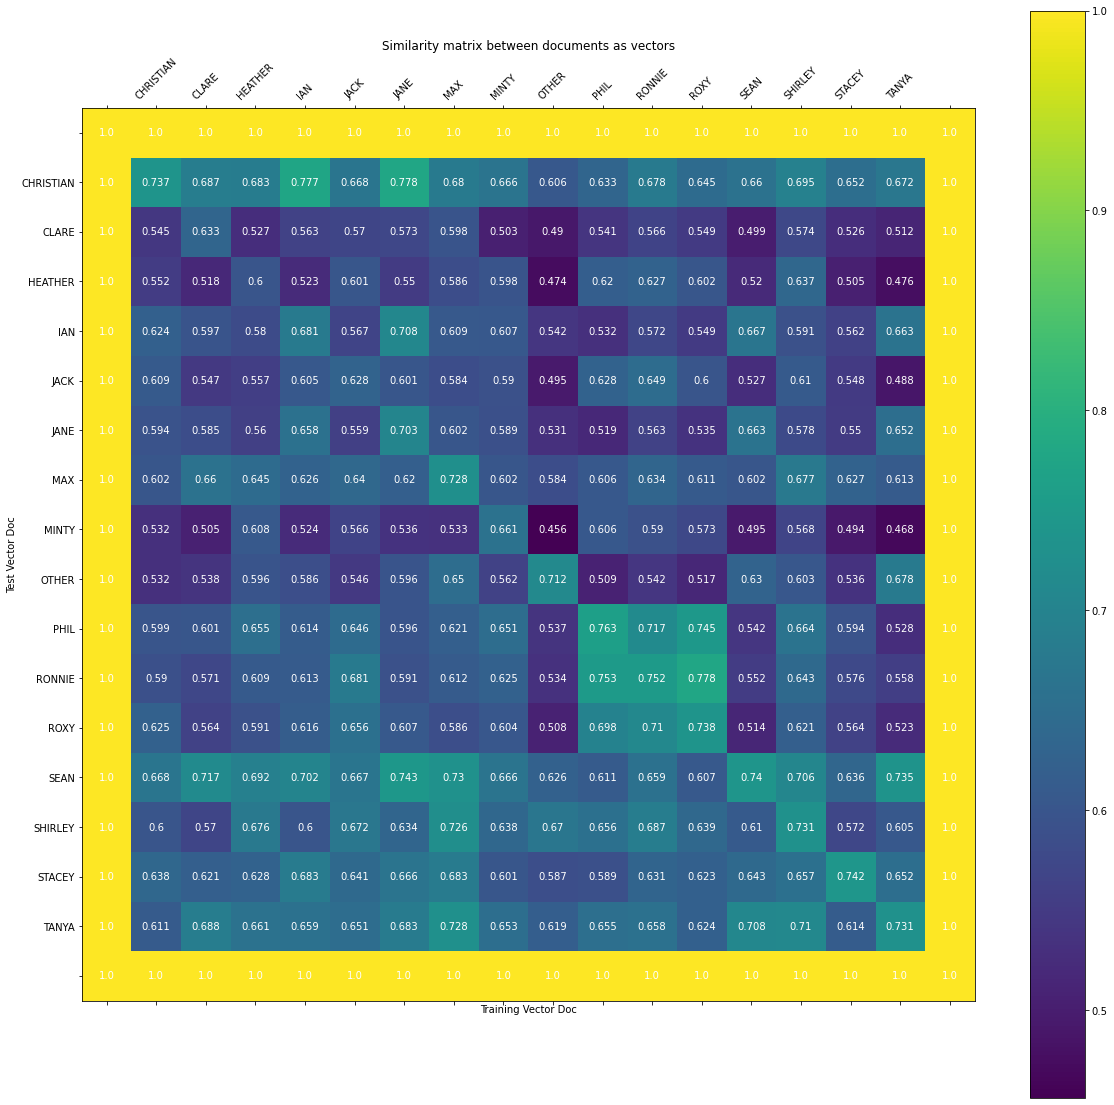

In [24]:
plot_heat_map_similarity(df)

# Q5. Select and test the best vector representation method

In [ ]:
# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
tfidf_transformer = TfidfTransformer()

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

lines per character {'SHIRLEY': 400, 'OTHER': 400, 'JACK': 400, 'RONNIE': 400, 'TANYA': 400, 'SEAN': 400, 'ROXY': 400, 'HEATHER': 400, 'MAX': 400, 'IAN': 400, 'JANE': 400, 'STACEY': 400, 'PHIL': 400, 'MINTY': 400, 'CHRISTIAN': 385, 'CLARE': 400}
Num. Characters:  16 

SHIRLEY Number of Words:  15274
OTHER Number of Words:  13191
JACK Number of Words:  15389
RONNIE Number of Words:  15799
TANYA Number of Words:  15228
SEAN Number of Words:  15402
ROXY Number of Words:  15447
HEATHER Number of Words:  16013
MAX Number of Words:  15912
IAN Number of Words:  16029
JANE Number of Words:  15417
STACEY Number of Words:  15563
PHIL Number of Words:  16403
MINTY Number of Words:  16443
CHRISTIAN Number of Words:  14818
CLARE Number of Words:  15869
total words 248197


# Best Final Result on Test Data --> mean rank= 1.4375
